Notebook to study bias frames from a CMOS image sensor and identify random telegraph signal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.stats import anderson, norm
import copy
import time

In [2]:
bias_stack_file = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/CMOS_nonlinearity_testing/ATIK_APX60/bias_stack.fits'
bias_stack = fits.open(bias_stack_file)[0].data.astype(np.int32)
gain = 42
# for data from qCMOS GUI
# bias_stack_file = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/CMOS_nonlinearity_testing/qCMOS_15550_no_sticker/bias_frames_20250715_144625_cube001.fits'
# bias_stack_file_2 = '/Users/layden/Library/CloudStorage/Box-Box/Scientific CMOS - MKI ONLY (might contain EAR; ITAR)/CMOS_nonlinearity_testing/qCMOS_15550_no_sticker/bias_frames_20250715_144625_cube002.fits'
# bias_stack = fits.open(bias_stack_file)[1].data.astype(np.int32)
# bias_stack_2 = fits.open(bias_stack_file_2)[1].data.astype(np.int32)
# bias_stack = np.concatenate((bias_stack, bias_stack_2), axis=0)
# gain = 9 # ADU/e-
var_frame_ADU = np.var(bias_stack, axis=0)
read_noise_frame = np.sqrt(var_frame_ADU) / gain
rms_read_noise = np.sqrt(np.mean(var_frame_ADU)) / gain
mean_read_noise = np.mean(read_noise_frame)
median_read_noise = np.median(read_noise_frame)

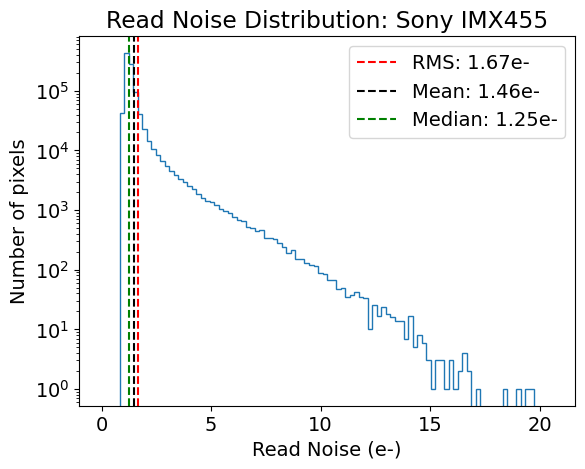

In [3]:
plt.rcParams['font.size'] = 14
plt.hist(read_noise_frame.flatten(), bins=100, range=(0,np.max(read_noise_frame) + 1), histtype='step')
plt.axvline(x=rms_read_noise, linestyle='--', c='r', label='RMS: ' + format(rms_read_noise, '3.2f') + 'e-')
plt.axvline(x=mean_read_noise, linestyle='--', c='k', label='Mean: ' + format(mean_read_noise, '3.2f') + 'e-')
plt.axvline(x=median_read_noise, linestyle='--', c='green', label='Median: ' + format(median_read_noise, '3.2f') + 'e-')
plt.legend()
plt.yscale('log')
plt.xlabel('Read Noise (e-)')
plt.ylabel('Number of pixels')
plt.title('Read Noise Distribution: Sony IMX455')
# plt.title('Read Noise Distribution in qcMOS')
plt.show()

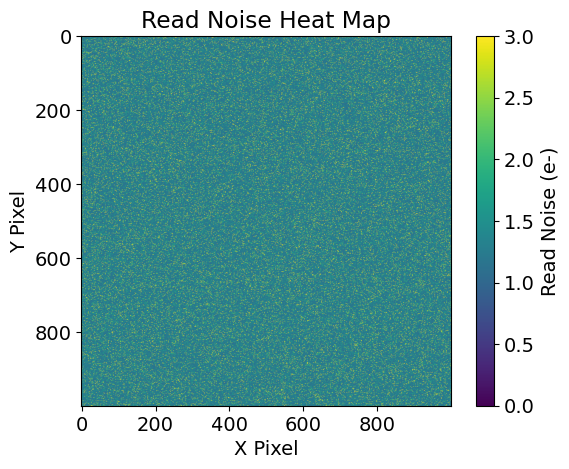

In [4]:
%matplotlib inline
# Make a heat map of the read noise
plt.imshow(read_noise_frame, cmap='viridis', vmin=0, vmax=3)
plt.colorbar(label='Read Noise (e-)')
plt.title('Read Noise Heat Map')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

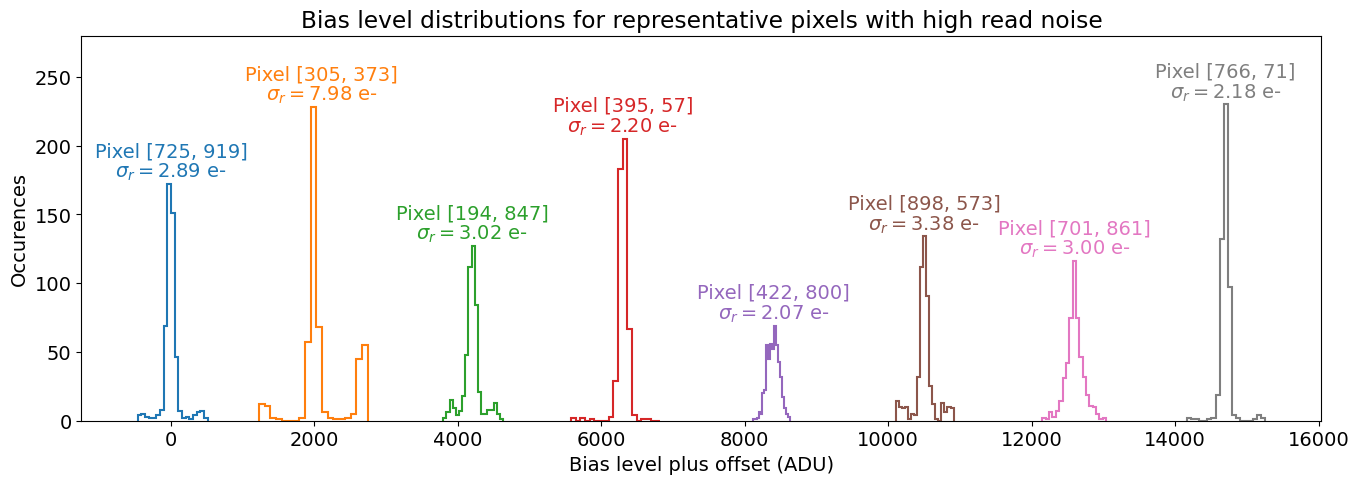

In [5]:
high_noise_idxs = np.argwhere(read_noise_frame > 2)
# Get random sample of 10 high noise pixels
np.random.seed(41)  # For reproducibility
sampled_idxs = np.random.choice(high_noise_idxs.shape[0], size=8, replace=False)
sample_high_noise_idxs = high_noise_idxs[sampled_idxs]
fig, ax = plt.subplots(figsize=(16, 5))
colors = plt.cm.tab10.colors  # Use a colormap for distinct colors
y_bound = 0
# Round spacing_per_pix to nearest 50
spacing_per_pix = round(gain * rms_read_noise * 30 / 50) * 50
for i, pix_idx in enumerate(sample_high_noise_idxs):
    pix_read_noise = read_noise_frame[pix_idx[0], pix_idx[1]]
    pix_bias_vals = bias_stack[:, pix_idx[0], pix_idx[1]]
    pix_mean_bias_val = round(np.mean(pix_bias_vals))
    color = colors[i % len(colors)]
    hist_plot_vals = pix_bias_vals - pix_mean_bias_val + i * spacing_per_pix
    # Get 1st percentile and 99th percentile for histogram binning
    low_bin = np.percentile(hist_plot_vals, 0.1)
    high_bin = np.percentile(hist_plot_vals, 99.9)
    # print if pixel has severe outlier outside of low_bin and high_bin
    if np.min(hist_plot_vals) < low_bin - gain * 5 or np.max(hist_plot_vals) > high_bin + gain * 5:
        print(f'Pixel {pix_idx} has severe outlier: min={np.min(hist_plot_vals)}, max={np.max(hist_plot_vals)}')
    pix_hist = ax.hist(
        hist_plot_vals,
        bins=np.linspace(low_bin, high_bin, 20),
        histtype='step',
        color=color,
        linewidth=1.5
    )
    # Add the pixel index above the histogram
    ax.text(
        i * spacing_per_pix,
        np.max(pix_hist[0]) + 20,
        f'Pixel [{pix_idx[0]}, {pix_idx[1]}]',
        ha='center',
        color=color
    )
    ax.text(
        i * spacing_per_pix,
        np.max(pix_hist[0]) + 5,
        r'$\sigma_r =$' + format(pix_read_noise, '3.2f') + ' e-',
        ha='center',
        color=color
    )
    y_bound = max(y_bound, np.max(pix_hist[0]) + 50)

ax.set_ylim(0, y_bound)
ax.set_xlabel('Bias level plus offset (ADU)')
ax.set_ylabel('Occurences')
ax.set_title('Bias level distributions for representative pixels with high read noise')
plt.show()

First part of the RTN detection pipeline: filter out pixels with Gaussian read noise distributions. Follows https://arxiv.org/pdf/2505.24540

First, we must address the discrete nature of the data. Following Ozdogru et al., we will add numbers randomly sampled from [-0.5, 0.5] to all values in bias_stack.

In [6]:
smoothing_arr = np.random.uniform(-0.5, 0.5, size=bias_stack.shape)
smoothed_bias_stack = bias_stack + smoothing_arr
# clear the smoothing_arr variable to free up memory
del smoothing_arr

Next, perform an Anderson-Darling normality test on every pixel. This is a vectorized version so it runs faster, particularly on GPUs (if using GPU, swap numpy for cupy)

In [ ]:
import numpy as np
from scipy.stats import norm

def ad_statistic_normal_per_pixel(data):
    # data: shape (n_samples, nx, ny)
    n, nx, ny = data.shape

    # Sort samples at each pixel
    sorted_data = np.sort(data, axis=0)  # shape: (n_samples, nx, ny)

    # Normalize to z-scores at each pixel
    mean = np.mean(sorted_data, axis=0, keepdims=True)
    std = np.std(sorted_data, axis=0, ddof=1, keepdims=True)
    z = (sorted_data - mean) / std

    # Compute normal CDF
    cdf = norm.cdf(z)

    # Clip CDF values to avoid log(0)
    eps = np.finfo(float).eps  # ~2.2e-16
    cdf = np.clip(cdf, eps, 1 - eps)

    # Compute A² statistic
    i = np.arange(1, n + 1).reshape(-1, 1, 1)
    term = (2 * i - 1) * (np.log(cdf) + np.log(1 - cdf[::-1, :, :]))
    A2 = -n - np.mean(term, axis=0)  # shape: (nx, ny)
    return A2


In [8]:
anderson_stat_arr = ad_statistic_normal_per_pixel(smoothed_bias_stack)

Number of pixels with Anderson-Darling statistic > 1.092: 167119


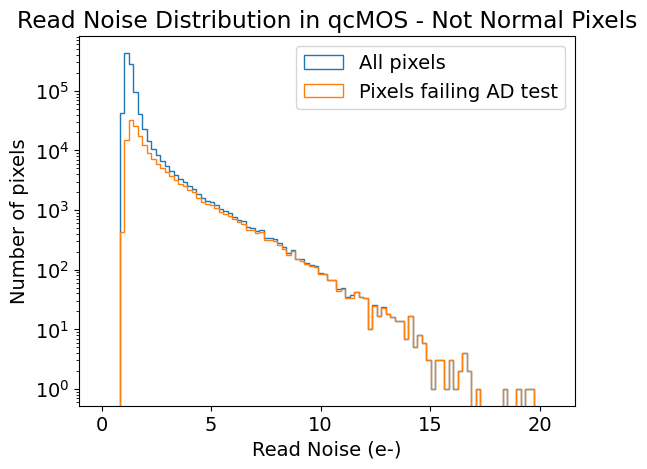

In [11]:
num_pixels_above_threshold = np.sum(anderson_stat_arr > 1.092)
print(f"Number of pixels with Anderson-Darling statistic > 1.092: {num_pixels_above_threshold}")
# Keep pixels in bias_stack where Anderson-Darling statistic is above threshold
mask = anderson_stat_arr > 1.092
not_normal_bias_stack = bias_stack[:, mask]
not_normal_read_noise_frame = read_noise_frame[mask]
# Make a histogram of read noise in all pixels and those that are not normal
plt.hist(read_noise_frame.flatten(), bins=100, range=(0, np.max(read_noise_frame) + 1), histtype='step', label='All pixels')
plt.hist(not_normal_read_noise_frame.flatten(), bins=100, range=(0, np.max(read_noise_frame) + 1), histtype='step', label='Pixels failing AD test')
plt.legend()
plt.yscale('log')
plt.xlabel('Read Noise (e-)')
plt.ylabel('Number of pixels')
plt.title('Read Noise Distribution in qcMOS - Not Normal Pixels')
plt.show()

Now for all pixels failing the normality test, fit to a triple Gaussian to determing if RTN is present

In [15]:
def rts_triple_gaussian(x, mu, A, B1, B2, d, sigma):
    central_gaussian = A * np.exp(- (x - mu) ** 2 / (2 * sigma) ** 2)
    left_gaussian = B1 * np.exp(- (x - d - mu) ** 2 / (2 * sigma) ** 2)
    right_gaussian = B2 * np.exp(- (x + d - mu) ** 2 / (2 * sigma) ** 2)
    return central_gaussian + left_gaussian + right_gaussian

[977.31484838 123.49010787  38.32922877   9.15970269 681.57685401
  31.81976393]


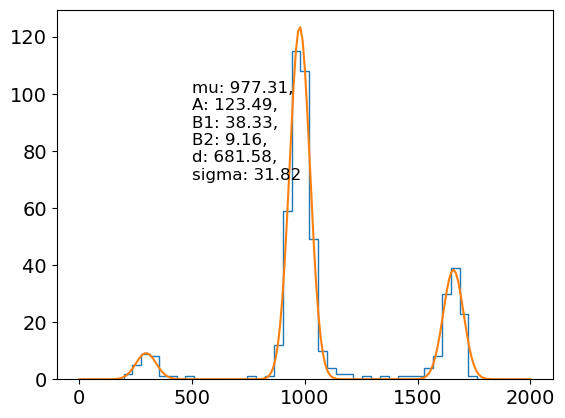

In [69]:
test_pix = bias_stack[:, sample_high_noise_idxs[1][0], sample_high_noise_idxs[1][1]]
# test_pix = bias_stack[:, 0, 0]
pix_hist = plt.hist(test_pix, bins=51, histtype='step', range=(0,2000))
bin_centers = (pix_hist[1][1:] + pix_hist[1][:-1]) / 2
hist_vals = pix_hist[0]
fit_params, covar_mat = curve_fit(rts_triple_gaussian, bin_centers, hist_vals, p0=(1000, max(hist_vals), 10, 10, 400, 50))
print(fit_params)
x_fit_vals = np.linspace(0, 2000, 201)
y_fit_vals = rts_triple_gaussian(x_fit_vals, *fit_params)
# Print labeled fit parameters on plot as text
fit_label = (f'mu: {fit_params[0]:.2f},\nA: {fit_params[1]:.2f},\nB1: {fit_params[2]:.2f},\n'
             f'B2: {fit_params[3]:.2f},\nd: {fit_params[4]:.2f},\nsigma: {fit_params[5]:.2f}')
plt.text(500, 70, fit_label, fontsize=12, ha='left')
plt.plot(x_fit_vals, y_fit_vals)
plt.show()

In [243]:
rts_corr_read_noise_frame = copy.deepcopy(read_noise_frame)
# In this array, columns are:
# 0: Pixel X, 1: Pixel Y, 2: Left Rel Amplitude, 3: Right Rel Amplitude, 4: Spacing, 5: Sigma
rtn_array = np.zeros((len(high_noise_idxs), 7))
rtn_pix_counter = 0
not_rtn_pix_counter = 0
num_failed_fits = 0  # Counter for failed fits
for i, pix_idx in enumerate(high_noise_idxs[:1000]):
    print(i)
    pix_read_noise = read_noise_frame[pix_idx[0], pix_idx[1]]
    pix_bias_vals = bias_stack[:, pix_idx[0], pix_idx[1]]
    pix_hist = np.histogram(pix_bias_vals, bins=51, range=(0, 2000))
    bin_centers = (pix_hist[1][1:] + pix_hist[1][:-1]) / 2
    hist_vals = pix_hist[0]
    try:
        fit_params, covar_mat = curve_fit(rts_triple_gaussian, bin_centers, hist_vals,
                                          p0=(1000, max(hist_vals), 20, 20, 400, 50), maxfev=20000,
                                          bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]))
        # sidelobe_identification_snr = fit_params[3] / np.sqrt(covar_mat[3, 3])
        # if sidelobe_identification_snr > 10:
        # print(fit_params)
        lam_max = (fit_params[4] / 3.5 / gain) ** 2 - (fit_params[5] / gain) ** 2
        A = fit_params[1] / (fit_params[1] + fit_params[2] + fit_params[3])
        # Only keep pixels with lam_max > 1 and A < 0.95
        if (lam_max > 1) and (A < 0.95):
            rtn_pix_counter += 1
            old_read_noise = read_noise_frame[pix_idx[0], pix_idx[1]]
            new_read_noise = fit_params[-1] / gain
            rts_corr_read_noise_frame[pix_idx[0], pix_idx[1]] = new_read_noise
            rtn_array[i, 0] = pix_idx[0]
            rtn_array[i, 1] = pix_idx[1]
            rtn_array[i, 2] = fit_params[0]
            rtn_array[i, 3] = fit_params[2] / fit_params[1]
            rtn_array[i, 4] = fit_params[3] / fit_params[1]
            rtn_array[i, 5] = fit_params[4]
            rtn_array[i, 6] = fit_params[5]
            print('Read noise for pixel ', pix_idx, ' adjusted from ', old_read_noise, ' to ', new_read_noise)
            print(fit_params)
            print(lam_max)
            # hist = plt.hist(pix_bias_vals, histtype='step')
            # x_fit_vals = np.linspace(0, 2000, 201)
            # y_fit_vals = rts_triple_gaussian(x_fit_vals, *fit_params) * np.max(hist[0]) / fit_params[1]
            # plt.plot(x_fit_vals, y_fit_vals)
            # plt.show()
        else:
            # continue
            not_rtn_pix_counter += 1
            print('RTS not detected to significant level in pixel', pix_idx)
    except Exception as e:
        # print(f'Failed to fit pixel {pix_idx}: {e}')
        # plt.plot(bin_centers, hist_vals, label=f'Pixel {pix_idx}')
        # plt.show()
        num_failed_fits += 1
        continue
# Drop empty rows from rtn_array
rtn_array = rtn_array[~np.all(rtn_array == 0, axis=1)]

0
RTS not detected to significant level in pixel [0 0]
1
RTS not detected to significant level in pixel [ 0 27]
2
Read noise for pixel  [ 0 29]  adjusted from  3.33946175548194  to  1.0142846179480227
[972.53404989 113.71549123   8.48277512   6.88517029 373.39421568
  42.59995395]
5.4233179859443394
3
Read noise for pixel  [ 0 30]  adjusted from  3.0293705815204257  to  0.7262928735448699
[1014.53556628  158.57638477    8.76028958    5.36442989  379.25363966
   30.50430069]
6.128675402687919
4
RTS not detected to significant level in pixel [ 0 35]
5
RTS not detected to significant level in pixel [ 0 36]
6
Read noise for pixel  [ 0 37]  adjusted from  2.91983323965467  to  0.9164334273477367
[981.91265263 100.74592588  24.81822978  19.06406243 206.56819644
  38.49020395]
1.1348093955612941
7
RTS not detected to significant level in pixel [ 0 38]
8
Read noise for pixel  [ 0 45]  adjusted from  4.254990165220414  to  1.1786158878125863
[1005.11172849   78.55458944   20.54828187   12.40782

In [244]:
print('Number of pixels identified with RTN:', rtn_pix_counter)
print('Number of pixels not identified with RTN:', not_rtn_pix_counter)
print('Number of failed fits:', num_failed_fits)

Number of pixels identified with RTN: 449
Number of pixels not identified with RTN: 551
Number of failed fits: 0


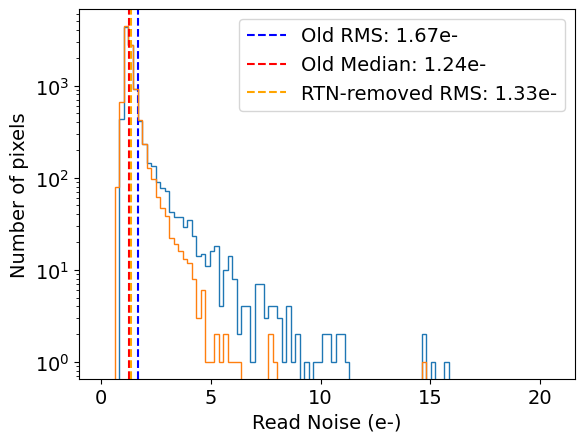

In [245]:
plt.hist(read_noise_frame[:10].flatten(), bins=100, range=(0,np.max(read_noise_frame) + 1), histtype='step')
plt.axvline(x=rms_read_noise, linestyle='--', c='blue', label='Old RMS: ' + format(rms_read_noise, '3.2f') + 'e-')
rts_corr_rms_read_noise = np.mean(np.sqrt(rts_corr_read_noise_frame[:10] ** 2))
read_noise_median = np.median(read_noise_frame[:10])
plt.hist(rts_corr_read_noise_frame[:10].flatten(), bins=100, range=(0,np.max(read_noise_frame) + 1), histtype='step')
plt.axvline(x=read_noise_median, linestyle='--', c='red', label='Old Median: ' + format(read_noise_median, '3.2f') + 'e-')
plt.axvline(x=rts_corr_rms_read_noise, linestyle='--', c='orange', label='RTN-removed RMS: ' + format(rts_corr_rms_read_noise, '3.2f') + 'e-')
plt.legend()
plt.yscale('log')
plt.xlabel('Read Noise (e-)')
plt.ylabel('Number of pixels')
plt.show()


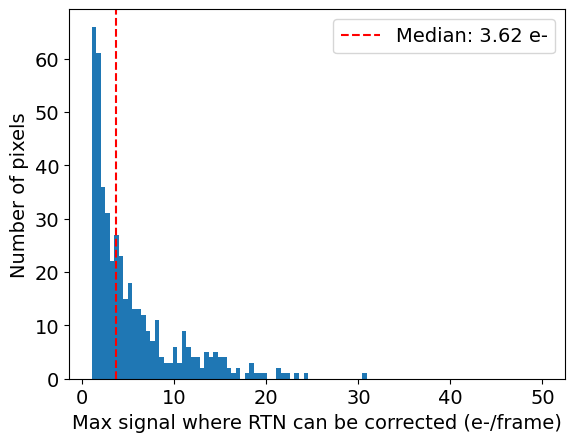

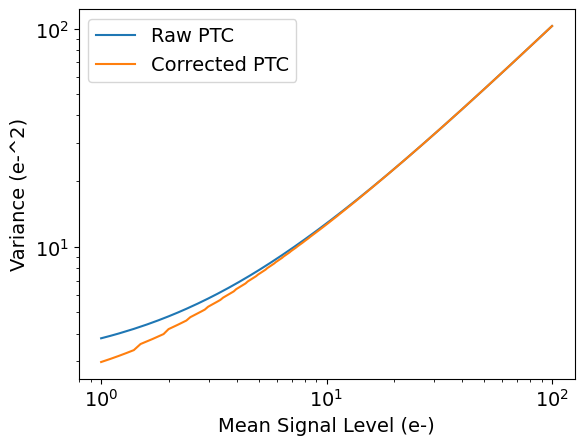

In [295]:
q_factor = 3.5
lambda_max_array = (rtn_array[:,5] / q_factor / gain) ** 2 - (rtn_array[:,6] / gain) ** 2
lam_max_hist = plt.hist(lambda_max_array, bins=100, range=(1, 50))
# Draw median
plt.axvline(x=np.median(lambda_max_array), linestyle='--', c='r', label='Median: ' + format(np.median(lambda_max_array), '3.2f') + ' e-')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Max signal where RTN can be corrected (e-/frame)')
plt.ylabel('Number of pixels')
plt.show()
# Plot what the PTC curve would look like with perfect correction up to lambda_max
mean_signal_levels = np.linspace(1, 100, 1000)
ptc_curve_raw = mean_signal_levels + rms_read_noise ** 2
ptc_curve_corr = mean_signal_levels * 1
for i, lam_max in enumerate(lam_max_hist[1][1:]):
    frac_in_bin = lam_max_hist[0][i] / np.sum(lam_max_hist[0])
    ptc_curve_corr += frac_in_bin * (mean_signal_levels > lam_max) * rms_read_noise ** 2
    ptc_curve_corr += frac_in_bin * (mean_signal_levels <= lam_max) * 1.4 ** 2
plt.plot(mean_signal_levels, ptc_curve_raw, label='Raw PTC')
plt.plot(mean_signal_levels, ptc_curve_corr, label='Corrected PTC')
plt.xlabel('Mean Signal Level (e-)')
plt.ylabel('Variance (e-^2)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
def correct_signal_vals(signal_vals, delta_x, lam, q, true_high_indices=None, true_low_indices=None, mu=0):
    corrected_vals = signal_vals.copy()
    # Check for points between lam + delta_x - q and lam + delta_x + q
    # high_indices = np.where(signal_vals > lam + q)[0]
    # low_indices = np.where(signal_vals < lam - q)[0]
    high_cutoff_low = np.max([mu + lam + delta_x - q, mu + lam + q])
    high_cutoff_high = mu + lam + delta_x + q
    high_indices = np.where((signal_vals > high_cutoff_low) & (signal_vals < high_cutoff_high))[0]
    low_cutoff_low = mu + lam - delta_x - q
    low_cutoff_high = np.min([mu + lam - q, mu + lam - delta_x + q])
    low_indices = np.where((signal_vals < low_cutoff_high) & (signal_vals > low_cutoff_low))[0]
    # This approach for double jumps doesn't work--double jumps aren't actually separated by 2 * delta_x
    # double_high_cutoff_low = mu + lam + 2 * delta_x - q
    # double_high_cutoff_high = mu + lam + 2 * delta_x + q
    # double_high_indices = np.where((signal_vals > double_high_cutoff_low) & (signal_vals < double_high_cutoff_high))[0]
    # double_low_cutoff_low = mu + lam - 2 * delta_x - q
    # double_low_cutoff_high = mu + lam - 2 * delta_x + q
    # double_low_indices = np.where((signal_vals < double_low_cutoff_high) & (signal_vals > double_low_cutoff_low))[0]
    corrected_vals[high_indices] -= delta_x
    corrected_vals[low_indices] += delta_x
    # corrected_vals[double_high_indices] -= 2 * delta_x
    # corrected_vals[double_low_indices] += 2 * delta_x
    # If true indices are provided, check precision and recall
    if true_high_indices is not None and true_low_indices is not None:
        # Check overlap between high_indices and true_high_indices
        true_positives_high = np.intersect1d(high_indices, true_high_indices)
        false_positives_high = len(high_indices) - len(true_positives_high)
        false_negatives_high = len(true_high_indices) - len(true_positives_high)
        # false_positive_rate = false_positives_high / len(corrected_vals)
        precision_high = len(true_positives_high) / (len(true_positives_high) + false_positives_high)
        recall_high = len(true_positives_high) / (len(true_positives_high) + false_negatives_high)
        # print(f"High Peak Correction - Precision: {precision_high:.3f}, Recall: {recall_high:.3f}")
    else:
        precision_high = None
        recall_high = None

    return corrected_vals, precision_high, recall_high

1.1806566764856405 5.59129133234813
4.044684273856027 -> 2.908525194440569


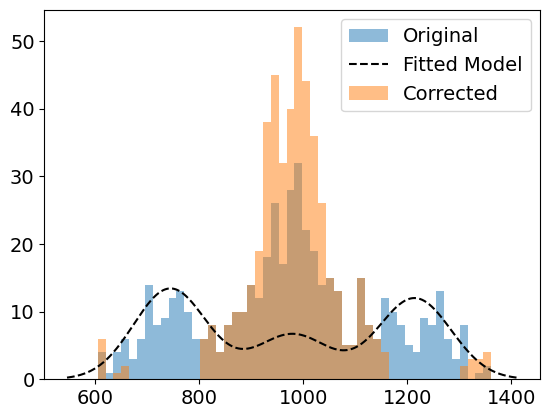

1.0602527902165007 15.580841579909244
5.930689130510602 -> 2.027192615327381


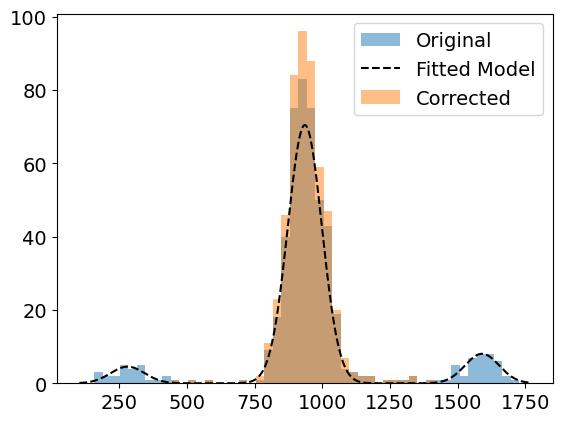

0.7354093399042337 15.611742098291044
4.770264398484003 -> 2.04008302234468


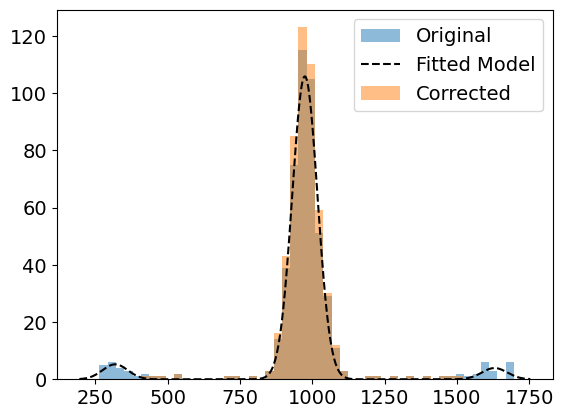

0.848031418241588 5.755067254685774
2.840017772856213 -> 1.1953583671933128


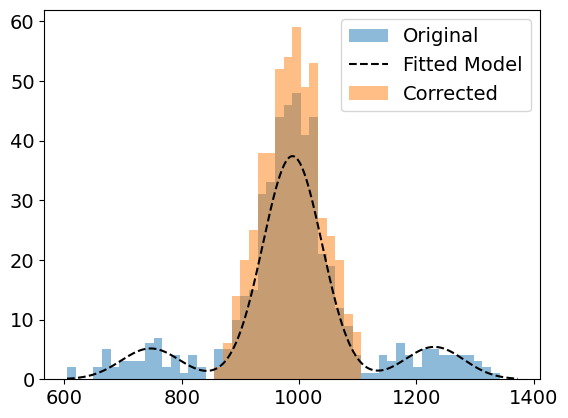

0.7857963293484492 5.549516593898441
2.4948058355422247 -> 1.0737211136590867


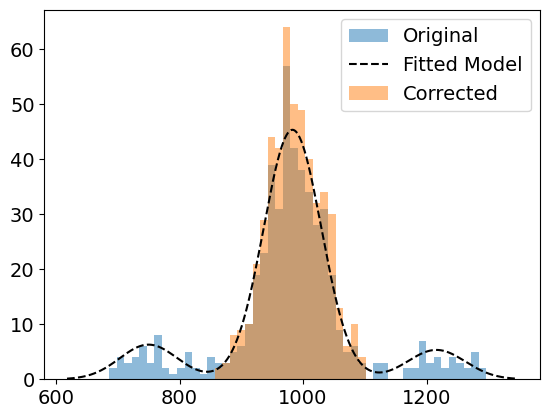

0.7530298531701786 9.930349199281968
3.7308941795712425 -> 1.4448074159168063


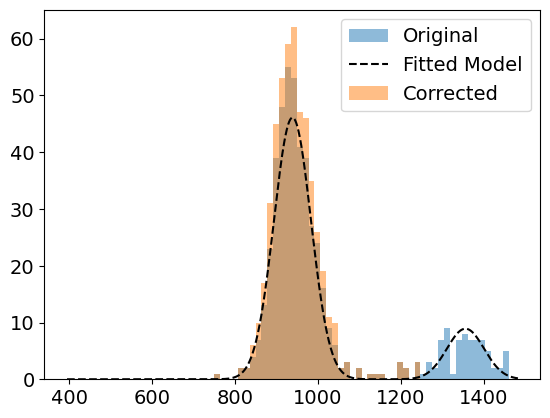

1.3192553460959058 6.074739320441848
5.344393048967634 -> 3.632758004324777


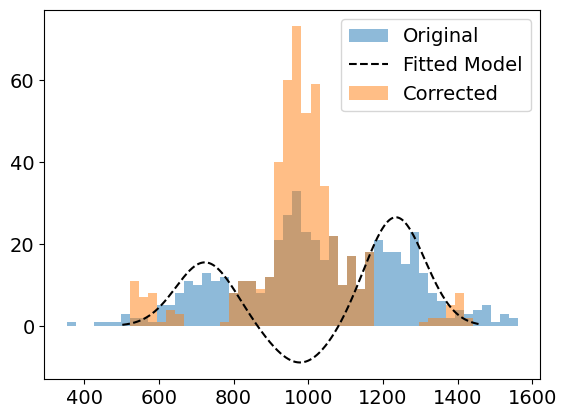

1.0734549744299653 5.8464618196380185
5.292531331380208 -> 2.2405862354096913


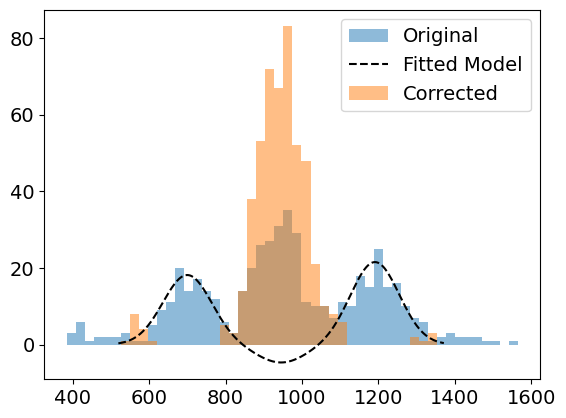

0.8525426334344847 5.004891685432955
2.4156957353864397 -> 1.3116805666968936


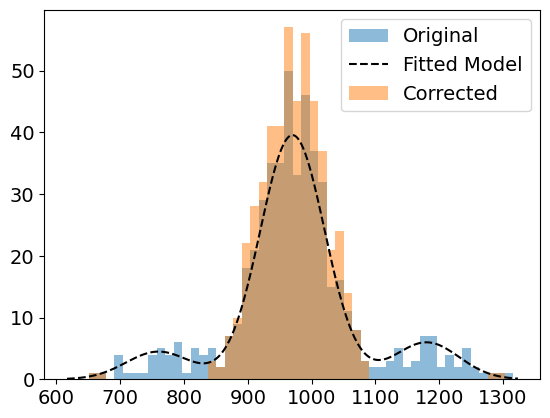

0.8903755913566048 8.976553492751615
2.4369170779273626 -> 1.2590275719052268


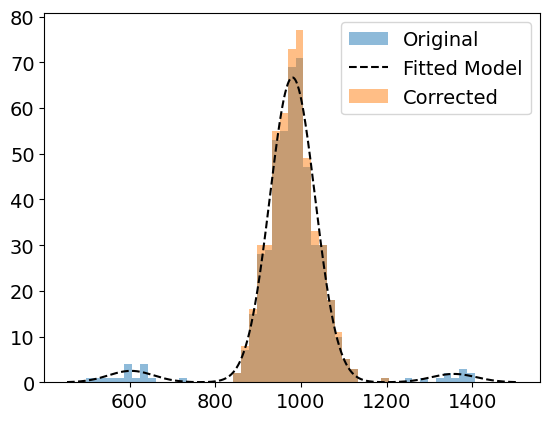

In [276]:
corrected_bias_stack = copy.deepcopy(bias_stack)
rtn_pixels_bias_stack = corrected_bias_stack[:, rtn_array[:,0].astype(int), rtn_array[:,1].astype(int)]
# for i in range(rtn_pixels_bias_stack.shape[1]):
for i in range(20,30):
    signal_vals = rtn_pixels_bias_stack[:, i].astype(np.float32)
    lam = 0
    mu = rtn_array[i, 2]
    delta_x = rtn_array[i, 5]
    A = 1 - rtn_array[i, 3] - rtn_array[i, 4]
    B = rtn_array[i, 3]
    sigma_r = rtn_array[i, 6]
    print(sigma_r / gain, delta_x / gain)
    q = 3.5 * np.sqrt(lam + sigma_r ** 2)
    corrected_signal_vals = correct_signal_vals(signal_vals, delta_x, lam, q, mu=mu)[0]
    corrected_bias_stack[:, rtn_array[i,0].astype(int), rtn_array[i,1].astype(int)] = corrected_signal_vals
    print(np.std(signal_vals) / gain, '->', np.std(corrected_signal_vals) / gain)
    hist = plt.hist(signal_vals, bins=50, alpha=0.5, label='Original')
    hist_vals = hist[0]
    hist_bins = hist[1]
    # Plot the fitted gaussians
    x_fit = np.linspace(mu - 4*sigma_r - delta_x, mu + delta_x + 4*sigma_r, 1000)
    y_fit = rts_triple_gaussian(x_fit, mu, A * np.max(hist_vals), B * np.max(hist_vals), (1-A-B) * np.max(hist_vals), delta_x, sigma_r)
    plt.plot(x_fit, y_fit, color='black', linestyle='--', label='Fitted Model')
    plt.hist(corrected_signal_vals, bins=hist_bins, alpha=0.5, label='Corrected')
    plt.legend()
    plt.show()

In [267]:
old_read_noise_vals = np.std(bias_stack[:,:10,:], axis=0) / gain
corrected_read_noise_vals = np.std(corrected_bias_stack[:,:10,:], axis=0) / gain
# corrected_read_noise_vals[corrected_read_noise_vals > 5] = 1
print(np.median(old_read_noise_vals), np.median(corrected_read_noise_vals))
print(np.sqrt(np.mean(corrected_read_noise_vals ** 2)), np.sqrt(np.mean(old_read_noise_vals ** 2)))

1.243707625424629 1.2406496459425858
1.4979937350079704 1.7052492913787842


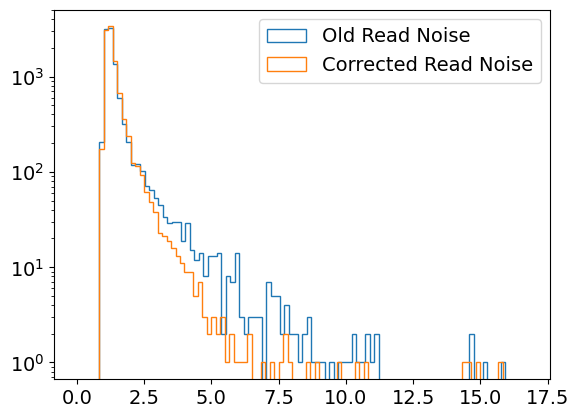

In [268]:
plt.hist(old_read_noise_vals.flatten(), bins=100, range=(0,np.max(old_read_noise_vals) + 1), histtype='step', label='Old Read Noise')
plt.hist(corrected_read_noise_vals.flatten(), bins=100, range=(0,np.max(corrected_read_noise_vals) + 1), histtype='step', label='Corrected Read Noise')
plt.legend()
plt.yscale('log')
plt.show()

In [117]:
np.sqrt(np.mean(read_noise_frame[:200] ** 2))

1.666440760591403